In [2]:
# import packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline 
plt.style.use('seaborn')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Project outline
The goal of my project is to perform a few tasks:
1. Analyze shopper behaviors (and maybe segmentation?)
2. Create shopping cart recommendation system for return customers (and maybe product
bundles for profit maximization?)
3. Predict whether the customer would like to re-order an item that they have purchased
before for their next purchase.
4. Flask app and demo that could show different product recommendation using different
user accounts to sign in.

Priority of task:
1 > 2 > 4 > 3

## Dataset background
- Instacart public dataset released in 2017 (https://www.instacart.com/datasets/grocery-shopping-2017)  
- In Instacart medium post, they provided more info about the dataset and motivation on why Instacart released the dataset (https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2).  

- The dataset has more than 3M grocery orders for more than 200k Instacart customers. 
- Data Dictionary could be found at https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b.
- The data file comes with 6 csv files.

In [3]:
# load all the csv obtained 
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
order_products_train = pd.read_csv('order_products__train.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')

### A peak of each csv

### aisles

In [4]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [5]:
# there are 134 different aisles
# with unique aisle id and aisle name
aisles.shape

(134, 2)

In [6]:
aisles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
aisle_id    134 non-null int64
aisle       134 non-null object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


### departments 

In [7]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [8]:
# there are 21 different unique department 
departments.shape

(21, 2)

### order_products_prior

In [9]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [10]:
order_products_prior.shape

(32434489, 4)

In [11]:
# there are 3214874 unique orders
len(order_products_prior.order_id.unique())

3214874

### order_products_train

In [12]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [13]:
order_products_train.shape

(1384617, 4)

In [14]:
len(order_products_train.order_id.unique())

131209

### orders

In [15]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [16]:
orders.shape

(3421083, 7)

## products

In [18]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [19]:
products.shape

(49688, 4)

## Explore more on orders

In [37]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [23]:
print(orders.shape)
print('there are', len(orders[orders.eval_set == 'prior']), 'entries for prior')
print('there are', len(orders[orders.eval_set == 'train']), 'entries for train')
print('there are', len(orders[orders.eval_set == 'test']), 'entries for test')

(3421083, 7)
there are 3214874 entries for prior
there are 131209 entries for train
there are 75000 entries for test


- there are 3221083 orders in total
- there are 3214874 orders that are prior
- there are 131209 orders that are in train set
- there are 75000 orders that are in test set

In [41]:
print('there are', len(orders[orders.eval_set == 'prior'].user_id.unique()), 'unique customers in total')
print('there are', len(orders[orders.eval_set == 'train'].user_id.unique()), 'unique customers in train set')
print('there are', len(orders[orders.eval_set == 'test'].user_id.unique()), 'unique customers in test set')

there are 206209 unique customers in total
there are 131209 unique customers in train set
there are 75000 unique customers in test set


since one user could have multiple orders, so I'm interested to see how many unique customer in the dataset
- there are 206209 unique customer in total, which match the description in data dictionary
- there are 131209 customers in the train set
- there are 75000 customers in the test set

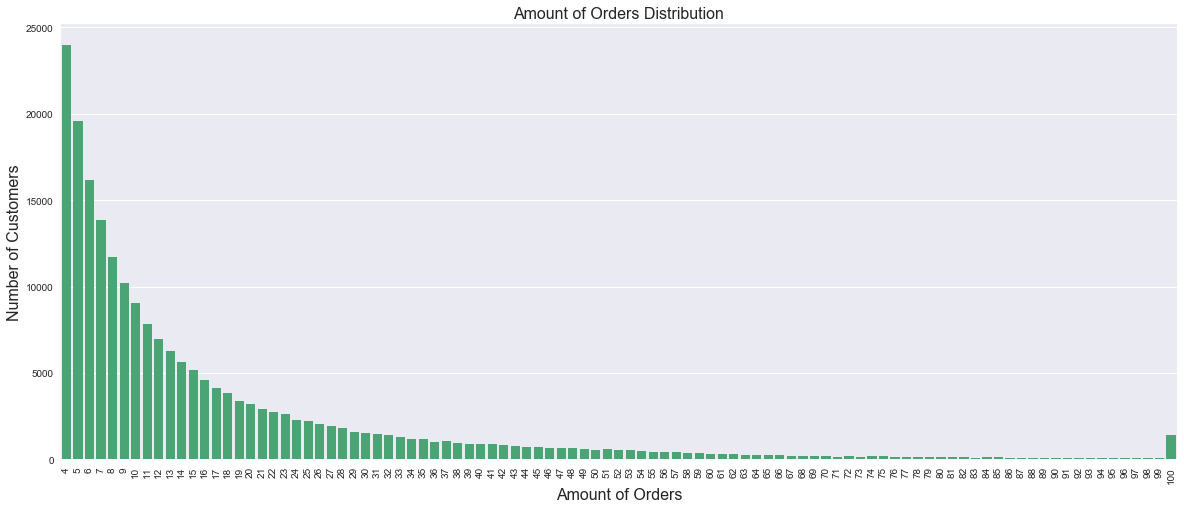

In [112]:
orders_amount_for_customer = orders.groupby('user_id')['order_number'].count().value_counts()

plt.figure(figsize=(20,8))
sns.barplot(x=orders_amount_for_customer.index, y=orders_amount_for_customer.values, color='mediumseagreen')
plt.title('Amount of Orders Distribution', fontsize=16)
plt.ylabel('Number of Customers', fontsize=16)
plt.xlabel('Amount of Orders', fontsize=16)
plt.xticks(rotation='vertical');

The amount of orders for each customers are between 4 to 100, which match the description in the data dictionary

''

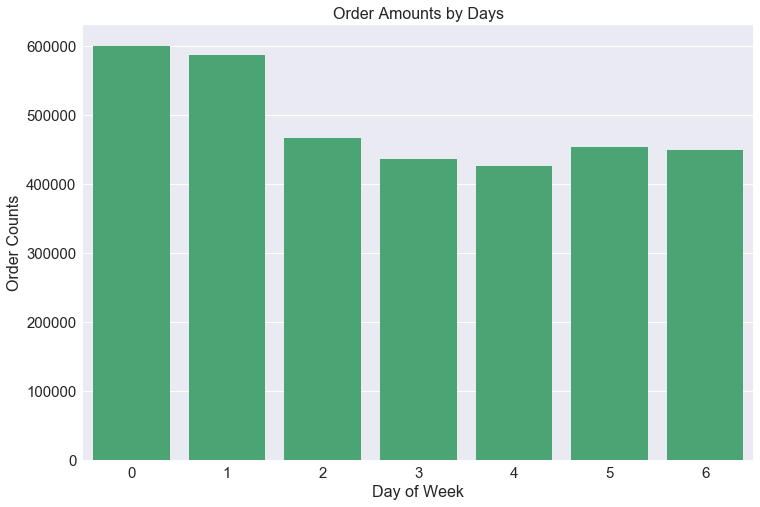

In [119]:
plt.figure(figsize=(12,8))
sns.countplot(x=orders.order_dow, color='mediumseagreen')

plt.title("Order Amounts by Days", fontsize=16)
plt.xlabel('Day of Week', fontsize=16)
plt.xticks(fontsize=15)
plt.ylabel('Order Counts', fontsize=16)
plt.yticks(fontsize=15)
;

- 0 and 1 has the most orders in a week, while 4 has the least
- not sure which day of week is corresponding to a number, maybe 0 is Sun and 6 is Sat?

''

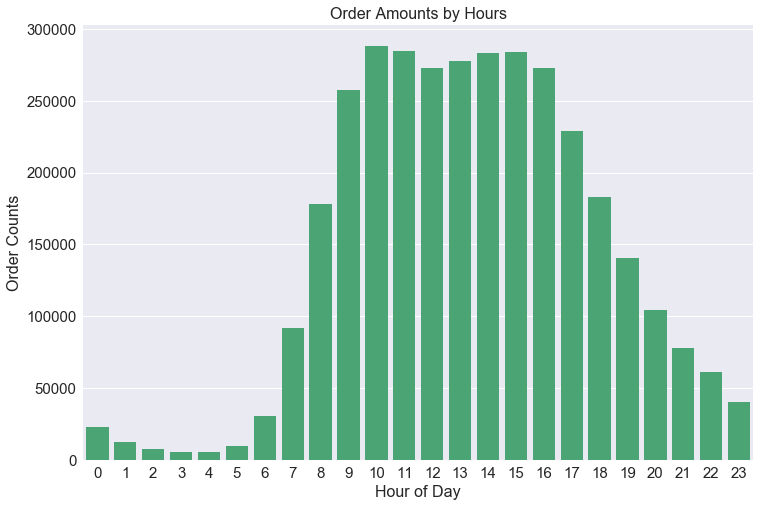

In [120]:
plt.figure(figsize=(12,8))
sns.countplot(x=orders.order_hour_of_day, color='mediumseagreen')

plt.title("Order Amounts by Hours", fontsize=16)
plt.xlabel('Hour of Day', fontsize=16)
plt.xticks(fontsize=15)
plt.ylabel('Order Counts', fontsize=16)
plt.yticks(fontsize=15)
;

- Looks like people like to order between 8am to 6pm, couldn't find the what the number corresponding to in data dictionary

''

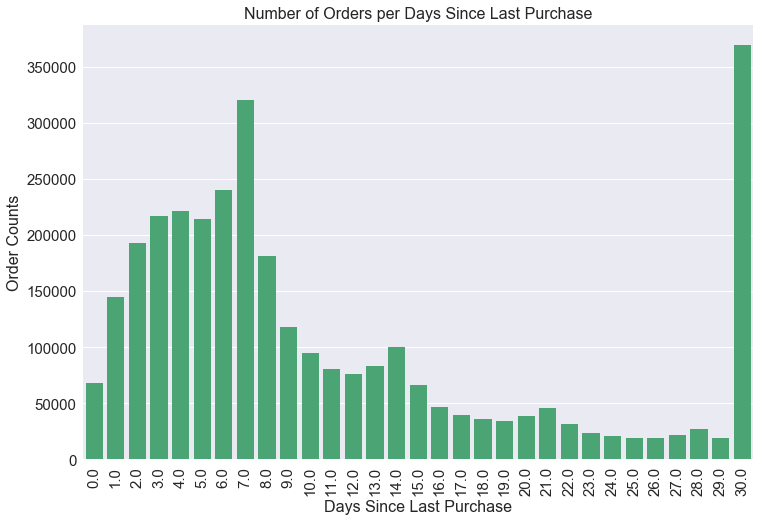

In [121]:
plt.figure(figsize=(12,8))
sns.countplot(x=orders.days_since_prior_order, color='mediumseagreen')

plt.title("Number of Orders per Days Since Last Purchase", fontsize=16)
plt.xlabel('Days Since Last Purchase', fontsize=16)
plt.xticks(fontsize=15)
plt.xticks(rotation='vertical')
plt.ylabel('Order Counts', fontsize=16)
plt.yticks(fontsize=15)
;

- looks like majority people order once a week, between 0 to 7.
- and there are people who order once more than 30 days.

## Explore more on order_product_prior & order_product_train

In [126]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [128]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [135]:
print(order_products_prior.shape)
print(order_products_train.shape)

(32434489, 4)
(1384617, 4)


In [150]:
order_products_total = pd.concat([order_products_prior, order_products_train])

print(order_products_total.shape)

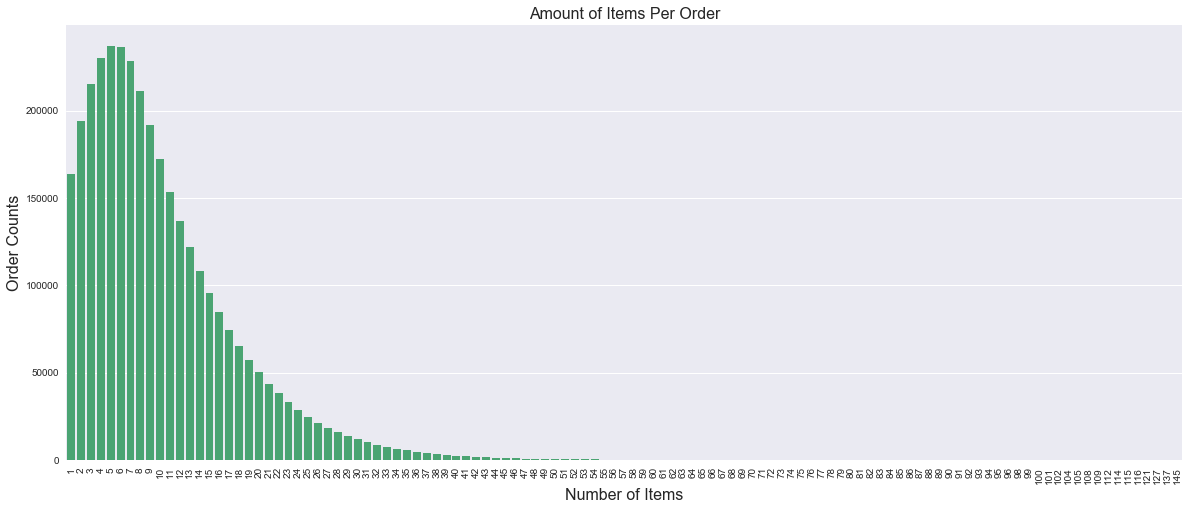

In [156]:
frequency_per_number_of_order = order_products_total.groupby('order_id')['product_id'].count().value_counts()

plt.figure(figsize=(20,8))
sns.barplot(x=frequency_per_number_of_order.index, y=frequency_per_number_of_order.values, color='mediumseagreen')
plt.title('Amount of Items Per Order', fontsize=16)
plt.ylabel('Order Counts', fontsize=16)
plt.xlabel('Number of Items', fontsize=16)
plt.xticks(rotation='vertical');

- looks like people msotly purchase 4 items per order
- looks like majority people like to purchase between 3 to 8 items per order

In [182]:
print('there are', order_products_total.shape[0], 'grocery products ordered')
print('there are', len(order_products_total.order_id.unique()), 'order transactions')
print('there are', len(order_products_total.product_id.unique()), 'unique products')

there are 33819106 grocery products ordered
there are 3346083 order transactions
there are 49685 unique products


In [184]:
print(len(order_products_total[order_products_total.reordered == 1])/order_products_total.shape[0], 'have reordered before')
print(len(order_products_total[order_products_total.reordered == 0])/order_products_total.shape[0], 'haven\'t reordered before')

0.5900617242809434 have reordered before
0.40993827571905656 haven't reordered before


In [181]:
print(len(order_products_total[order_products_total.reordered == 1]), 'products have reordered before')
print(len(order_products_total[order_products_total.reordered == 0]), 'products haven\'t reordered before')

19955360 products have reordered before
13863746 products haven't reordered before


## Explore more on aisles, departments & products

In [185]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [186]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [187]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [189]:
print(aisles.shape)
print(departments.shape)
print(products.shape)

(134, 2)
(21, 2)
(49688, 4)


In [196]:
products_departments = products.merge(departments, left_on='department_id', right_on='department_id', how='left')
products_departments_aisles = products_departments.merge(aisles, left_on='aisle_id', right_on='aisle_id', how='left')
products_departments_aisles.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation


In [216]:
products_departments_aisles.groupby('department')['product_id'].count().reset_index().sort_values(by='product_id', ascending=False).head(10)

,department,product_id
17,personal care,6563
20,snacks,6264
16,pantry,5371
3,beverages,4365
10,frozen,4007
7,dairy eggs,3449
11,household,3085
6,canned goods,2092
9,dry goods pasta,1858
19,produce,1684


## Explore more on products_departments_aisles & order_products_total

In [218]:
order_products_total.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [224]:
products_departments_aisles.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation


In [223]:
df = order_products_total.merge(products_departments_aisles, left_on='product_id', right_on='product_id', how='left')
df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,dairy eggs,eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,produce,fresh vegetables
2,2,9327,3,0,Garlic Powder,104,13,pantry,spices seasonings
3,2,45918,4,1,Coconut Butter,19,13,pantry,oils vinegars
4,2,30035,5,0,Natural Sweetener,17,13,pantry,baking ingredients


In [227]:
df.shape

(33819106, 9)

In [237]:
top_15_products = df.product_name.value_counts(ascending=False).reset_index().head(15)
top_15_products.columns = ['product_name', 'count']
top_15_products

,product_name,count
0,Banana,491291
1,Bag of Organic Bananas,394930
2,Organic Strawberries,275577
3,Organic Baby Spinach,251705
4,Organic Hass Avocado,220877
5,Organic Avocado,184224
6,Large Lemon,160792
7,Strawberries,149445
8,Limes,146660
9,Organic Whole Milk,142813


- the top 15 items that people purchase the most are above.
- most of them are organic fruits/veggies. all of them are fruits/veggies.

In [241]:
top_15_aisles = df.aisle.value_counts(ascending=False).reset_index().head(15)
top_15_aisles.columns = ['aisle_name', 'count']
top_15_aisles

,aisle_name,count
0,fresh fruits,3792661
1,fresh vegetables,3568630
2,packaged vegetables fruits,1843806
3,yogurt,1507583
4,packaged cheese,1021462
5,milk,923659
6,water seltzer sparkling water,878150
7,chips pretzels,753739
8,soy lactosefree,664493
9,bread,608469


In [243]:
top_15_department = df.department.value_counts(ascending=False).reset_index().head(15)
top_15_department.columns = ['department_name', 'count']
top_15_department

,department_name,count
0,produce,9888378
1,dairy eggs,5631067
2,snacks,3006412
3,beverages,2804175
4,frozen,2336858
5,pantry,1956819
6,bakery,1225181
7,canned goods,1114857
8,deli,1095540
9,dry goods pasta,905340


In [245]:
df.groupby('department')

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,dairy eggs,eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,produce,fresh vegetables
2,2,9327,3,0,Garlic Powder,104,13,pantry,spices seasonings
3,2,45918,4,1,Coconut Butter,19,13,pantry,oils vinegars
4,2,30035,5,0,Natural Sweetener,17,13,pantry,baking ingredients


In [249]:
reorder_ratio_per_dep = df.groupby('department')['reordered'].mean().reset_index()
reorder_ratio_per_dep.columns = ['department', 'reorder_ratio']
reorder_ratio_per_dep.sort_values(by='reorder_ratio', ascending=False)

,department,reorder_ratio
7,dairy eggs,0.670161
3,beverages,0.653651
19,produce,0.650521
2,bakery,0.628381
8,deli,0.608130
18,pets,0.602557
1,babies,0.577680
5,bulk,0.577090
20,snacks,0.574464
0,alcohol,0.571221


''

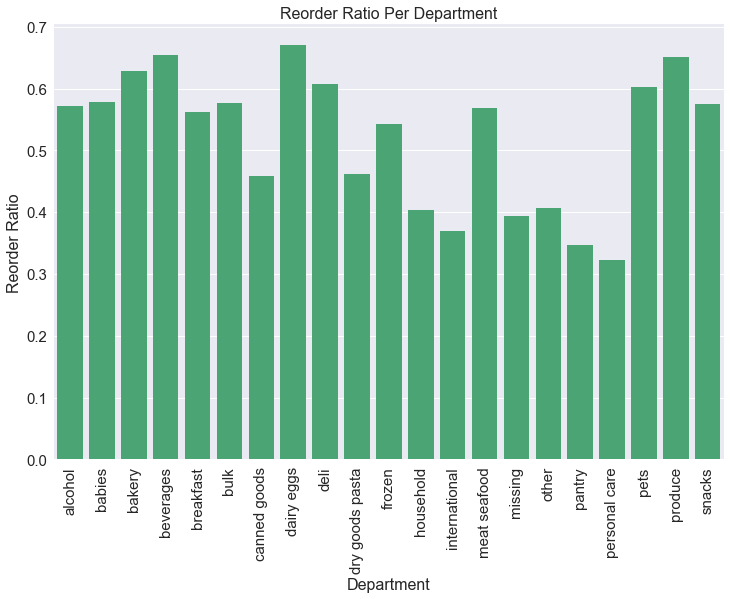

In [270]:
plt.figure(figsize=(12,8))
sns.barplot(x=reorder_ratio_per_dep.department, y=reorder_ratio_per_dep.reorder_ratio, color='mediumseagreen')
plt.title('Reorder Ratio Per Department', fontsize=16)
plt.xlabel('Department', fontsize=16)
plt.xticks(fontsize=15)
plt.xticks(rotation='vertical')
plt.ylabel('Reorder Ratio', fontsize=16)
plt.yticks(fontsize=15)
;

- dairy eggs has the most reorder ratio
- personal care has the least reorder ratio

In [271]:
df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,dairy eggs,eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,produce,fresh vegetables
2,2,9327,3,0,Garlic Powder,104,13,pantry,spices seasonings
3,2,45918,4,1,Coconut Butter,19,13,pantry,oils vinegars
4,2,30035,5,0,Natural Sweetener,17,13,pantry,baking ingredients


In [274]:
reorder_ratio_per_aisle = df.groupby('aisle')['reordered'].mean().reset_index()
reorder_ratio_per_aisle.columns = ['aisle', 'reorder_ratio']
reorder_ratio_per_aisle.sort_values(by='reorder_ratio', ascending=False)

,aisle,reorder_ratio
83,milk,0.781812
131,water seltzer sparkling water,0.729930
50,fresh fruits,0.718823
41,eggs,0.706359
119,soy lactosefree,0.692361
96,packaged produce,0.691977
133,yogurt,0.686501
33,cream,0.685184
11,bread,0.670552
110,refrigerated,0.663006


- milk aisle has the highest reorder ratio
- spices seasonings has the least reorder ratio

In [294]:
top_15_reorder_items = df.groupby('product_name')['reordered'].sum().reset_index().sort_values(by='reordered', ascending=False).head(15)
top_15_reorder_items

,product_name,reordered
3677,Banana,415166
3472,Bag of Organic Bananas,329275
31923,Organic Strawberries,214448
28843,Organic Baby Spinach,194939
30300,Organic Hass Avocado,176173
28807,Organic Avocado,140270
32481,Organic Whole Milk,118684
22415,Large Lemon,112178
31366,Organic Raspberries,109688
42908,Strawberries,104588


In [295]:
df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,dairy eggs,eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,produce,fresh vegetables
2,2,9327,3,0,Garlic Powder,104,13,pantry,spices seasonings
3,2,45918,4,1,Coconut Butter,19,13,pantry,oils vinegars
4,2,30035,5,0,Natural Sweetener,17,13,pantry,baking ingredients


In [302]:
add_to_cart_order_reordered_ratio = df.groupby('add_to_cart_order')['reordered'].mean().reset_index()
add_to_cart_order_reordered_ratio.head()

,add_to_cart_order,reordered
0,1,0.679302
1,2,0.677135
2,3,0.658426
3,4,0.637350
4,5,0.617598


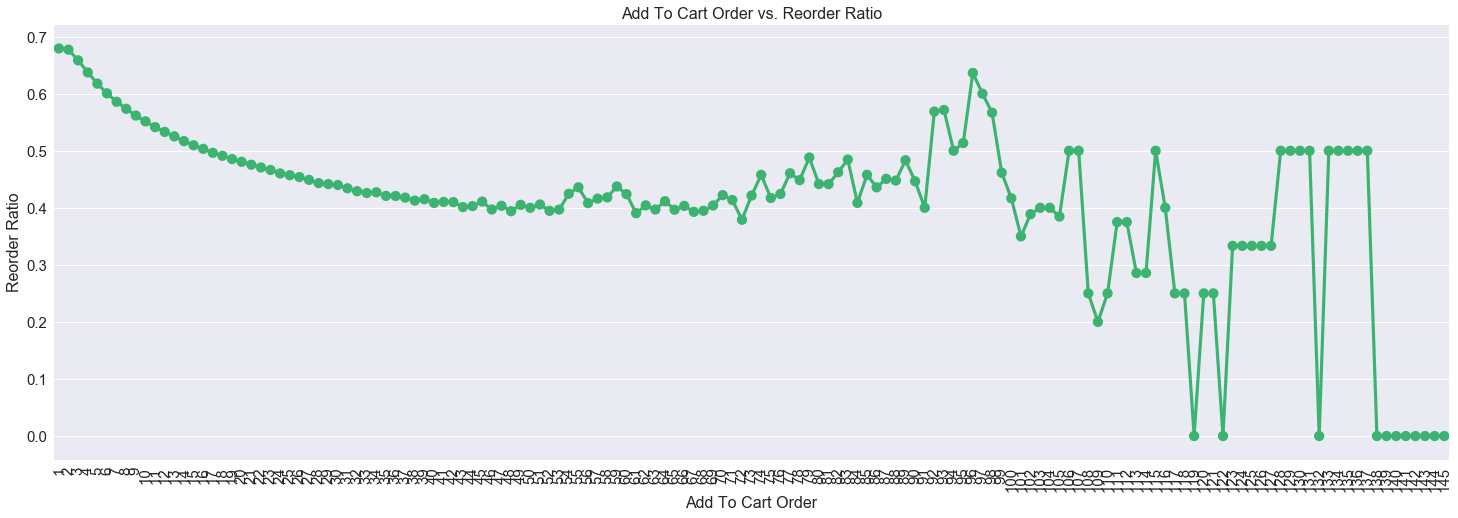

In [307]:
plt.figure(figsize=(25,8))
sns.pointplot(add_to_cart_order_reordered_ratio.add_to_cart_order, add_to_cart_order_reordered_ratio.reordered, color='mediumseagreen')
plt.title('Add To Cart Order vs. Reorder Ratio', fontsize=16)
plt.xlabel('Add To Cart Order', fontsize=16)
plt.xticks(fontsize=15)
plt.xticks(rotation='vertical')
plt.ylabel('Reorder Ratio', fontsize=16)
plt.yticks(fontsize=15);

## looking what items are ordered before noon, and what items are ordered after noon

In [357]:
# remove any rows referring to the test set
df_orders = orders[orders.eval_set != 'test']

# drop the eval_set column
df_orders = df_orders.drop(['eval_set'], axis=1)

# concatenate the _prior and _train datasets
df_order_products = pd.concat([order_products_prior, order_products_train])

# expand every order_id with the list of product_ids in that order_id
temp = df_orders.merge(df_order_products, on='order_id')
temp.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,1,2,8,NaN,196,1,0
1,2539329,1,1,2,8,NaN,14084,2,0
2,2539329,1,1,2,8,NaN,12427,3,0
3,2539329,1,1,2,8,NaN,26088,4,0
4,2539329,1,1,2,8,NaN,26405,5,0


In [359]:
## Keep only the top 2000 products
top_products = pd.DataFrame({'total_count': temp.groupby('product_id').size()}).sort_values('total_count', ascending=False).reset_index()[:2000]
top_products = top_products.merge(products, on='product_id')
top_products.head()

,product_id,total_count,product_name,aisle_id,department_id
0,24852,491291,Banana,24,4
1,13176,394930,Bag of Organic Bananas,24,4
2,21137,275577,Organic Strawberries,24,4
3,21903,251705,Organic Baby Spinach,123,4
4,47209,220877,Organic Hass Avocado,24,4


In [360]:
# keep only observations that have products in top_products
temp = temp.loc[temp['product_id'].isin(top_products.product_id)]

In [361]:
product_orders_by_hour = pd.DataFrame({'count': temp.groupby(['product_id', 'order_hour_of_day']).size()}).reset_index()
product_orders_by_hour['pct'] = product_orders_by_hour.groupby('product_id')['count'].apply(lambda x: x/x.sum()*100)
product_orders_by_hour.head(24)

,product_id,order_hour_of_day,count,pct
0,34,0,23,0.339283
1,34,1,18,0.265526
2,34,2,11,0.162266
3,34,3,5,0.073757
4,34,4,5,0.073757
5,34,5,15,0.221272
6,34,6,57,0.840832
7,34,7,202,2.979791
8,34,8,402,5.930078
9,34,9,509,7.508482


In [362]:
mean_hour = pd.DataFrame({'mean_hour': product_orders_by_hour.groupby('product_id').apply(lambda x: sum(x['order_hour_of_day'] * x['count'])/sum(x['count']))}).reset_index()
mean_hour.head()

,product_id,mean_hour
0,34,13.511285
1,45,13.398624
2,79,13.502530
3,116,12.516822
4,117,13.392173


In [364]:
morning = mean_hour.sort_values('mean_hour')[:25]
morning = morning.merge(products, on='product_id')
morning.head()

,product_id,mean_hour,product_name,aisle_id,department_id
0,9292,11.767279,Half And Half Ultra Pasteurized,84,16
1,46562,11.898340,Sweet & Salty Nut Granola Bars Peanut,3,19
2,45051,12.004019,Pub Mix,107,19
3,36472,12.049459,Nutri Grain Bars Multi Pack,48,14
4,37710,12.059043,Trail Mix,125,19


In [365]:
afternoon = mean_hour.sort_values('mean_hour', ascending=False)[:25]
afternoon = afternoon.merge(products, on='product_id')
afternoon.head()

,product_id,mean_hour,product_name,aisle_id,department_id
0,30668,14.526986,Half Baked Frozen Yogurt,37,1
1,45541,14.526299,The Tonight Dough™ Ice Cream,37,1
2,45681,14.394912,Americone Dream® Ice Cream,37,1
3,46175,14.388942,Half Baked® Ice Cream,37,1
4,14335,14.373308,Phish Food® Ice Cream,37,1


In [366]:
morning_pct = product_orders_by_hour.merge(morning, on='product_id').sort_values(['mean_hour', 'order_hour_of_day'])
afternoon_pct = product_orders_by_hour.merge(afternoon, on='product_id').sort_values(['mean_hour', 'order_hour_of_day'], ascending=False)

In [367]:
# get list of morning and afteroon product names
morning_product_names = list(morning_pct['product_name'].unique())
morning_product_names = '\n'.join(morning_product_names)
afternoon_product_names = list(afternoon_pct['product_name'].unique())
afternoon_product_names = '\n'.join(afternoon_product_names)

# hack to remove 'Variety Pack' from Orange & Lemon Flavor Variety Pack Sparkling Fruit Beverage
morning_product_names = morning_product_names.replace('Variety Pack ', '')

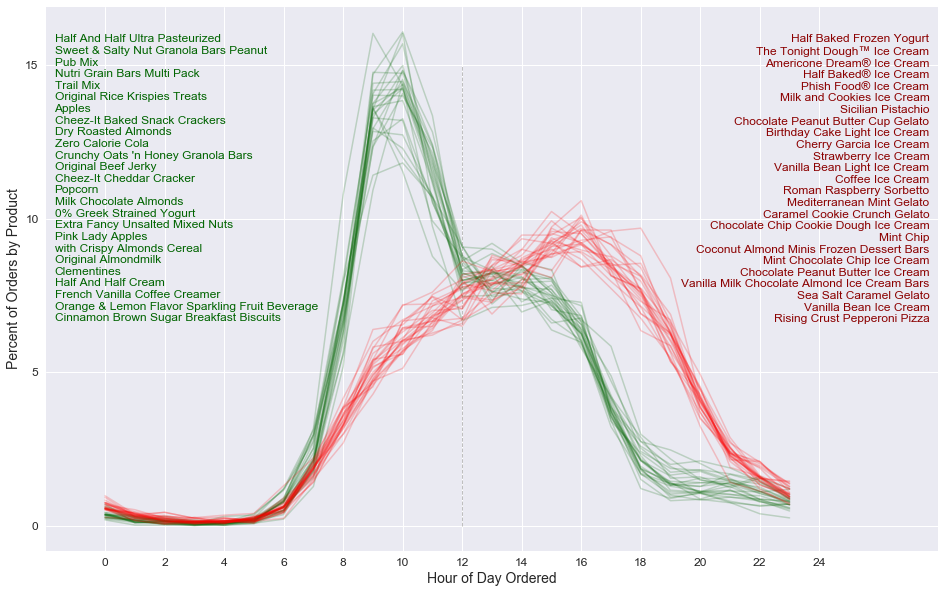

In [377]:
# Figure Size
fig, ax = plt.subplots(figsize=(16, 10))

# Plot
morning_pct.groupby('product_id').plot(x='order_hour_of_day', 
                                       y='pct', 
                                       ax=ax, 
                                       legend=False,
                                       alpha=0.2,
                                       aa=True,
                                       color='darkgreen',
                                       linewidth=1.5,)
afternoon_pct.groupby('product_id').plot(x='order_hour_of_day', 
                                         y='pct', 
                                         ax=ax, 
                                         legend=False,
                                         alpha=0.2,
                                         aa=True,
                                         color='red',
                                         linewidth=1.5,)

# Aesthetics
# Margins
plt.margins(x=0.5, y=0.05)

# Hide spines
for spine in ax.spines.values():
    spine.set_visible(False)

# Labels
label_font_size = 14
plt.xlabel('Hour of Day Ordered', fontsize=label_font_size)
plt.ylabel('Percent of Orders by Product', fontsize=label_font_size)

# Tick Range
tick_font_size = 12
ax.tick_params(labelsize=tick_font_size)
plt.xticks(range(0, 25, 2))
plt.yticks(range(0, 16, 5))
plt.xlim([-2, 28])

# Vertical line at noon
plt.vlines(x=12, ymin=0, ymax=15, alpha=0.5, color='gray', linestyle='dashed', linewidth=1.0)

# Text
text_font_size = 12
ax.text(0.01, 0.95, morning_product_names,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes,
        color='darkgreen', fontsize=text_font_size)
ax.text(0.99, 0.95, afternoon_product_names,
        verticalalignment='top', horizontalalignment='right',
        transform=ax.transAxes,
        color='darkred', fontsize=text_font_size);